In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from pprint import pprint
from functools import partial
from glob import glob
import cftime
import json
import string

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import drift_functions
import sn_plotting
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Logging
logger = utils.get_notebook_logger()

In [2]:
import listXarray as lxr
reload(lxr)
from listXarray import listXarray

# Opening Data

In [3]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', logginglevel='ERROR').to_dataarray('tas').sort_by_refkey()

In [4]:
pct_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1pct', 'tas').to_dataarray('tas').sort_by_refkey()

In [5]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
- r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
- r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
- r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc
- CESM2
- r1i1p1f1 - /g/dat

In [6]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [7]:
# Only selecting one ensemble member for each model
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0)
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0)
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0)

In [8]:
a1_raw_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
['CanESM5']     ({'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'model': 1, 'time': 2976, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'model': 1, 'time': 2220, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 1200, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'model': 1, 'time': 3960, 'lat': 144, 'lon': 192})

# Global Mean Calculation

In [9]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [10]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')
pct_regrid_xrlist = pct_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')
a1_regrid_xrlist = a1_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')

In [11]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')

In [12]:
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
['MPI-ESM1-2-LR']({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
['ACCESS-ESM1-5']({'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['CanESM5']     ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['GFDL-ESM4']   ({'model': 1, 'time': 200, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'time': 180, 'lat': 96, 'lon': 192})
['MIROC-ES2L']  ({'model': 1, 'time': 248, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['UKESM1-0-LL'] ({'model': 1, 'time': 330, 'lat': 96, 'lon': 192})

In [13]:
# Subsetting to only first 150 years so all models have equal footing
esmpi_xrlist = esmpi_xrlist.isel(time=slice(None, 165))

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
['MPI-ESM1-2-LR']({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['ACCESS-ESM1-5']({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['CanESM5']     ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['GFDL-ESM4']   ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['MIROC-ES2L']  ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
['UKESM1-0-LL'] ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})

In [14]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.apply(sn.calculate_global_value, 'tas').compute()
a1_smean_xrlist = a1_xrlist.apply(sn.calculate_global_value, 'tas').compute()
esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, 'tas').compute()

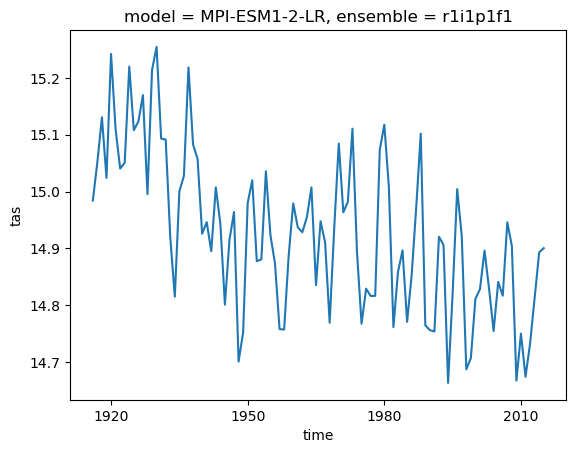

In [15]:
a1_smean_xrlist[0].plot()

In [16]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='INFO') for model in pct_smean_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

In [17]:
# The amomaly time series from the branch point
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()

In [18]:
a1_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
['MPI-ESM1-2-LR']({'model': 1, 'time': 100})
['ACCESS-ESM1-5']({'model': 1, 'time': 100})
['CESM2']       ({'model': 1, 'time': 100})
['CanESM5']     ({'model': 1, 'time': 100})
['GFDL-ESM4']   ({'model': 1, 'time': 100})
['GISS-E2-1-G-CC']({'model': 1, 'time': 100})
['MIROC-ES2L']  ({'model': 1, 'time': 100})
['NorESM2-LM']  ({'model': 1, 'time': 100})
['UKESM1-0-LL'] ({'model': 1, 'time': 100})

In [19]:
# Merging the 1% and the A1 experiment
to_concat = []
transition_arg_dict = {}
for model in pct_smean_xrlist.refkeys:
    ds_pct = pct_smean_xrlist[model]
    ds_a1 = a1_smean_xrlist[model]
    
    ds_total = ds_pct.sel(time=slice(None, ds_a1.time.values[0])).combine_first(ds_a1)
    # The integer location where the transition to the A1 experiment occured
    transition_arg_dict[model] = np.where(ds_total.time.values == ds_a1.time.values[0])[0][0]
    to_concat.append(ds_total)
a1_pct_smean_anom_xrlist = listXarray(to_concat)

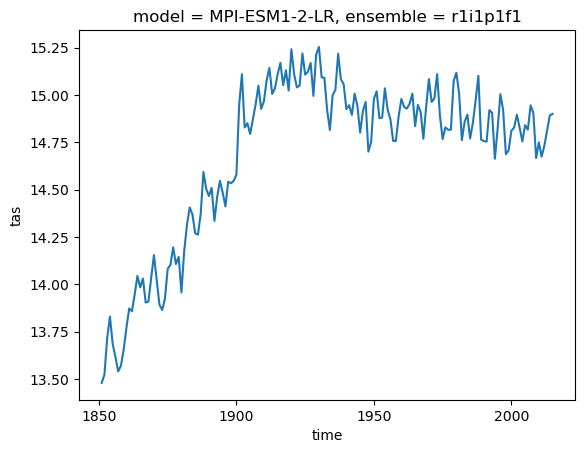

In [20]:
a1_pct_smean_anom_xrlist[0].plot()

In [21]:
# All modles now have matching coordinates - can now be converted to xarray
# previosly a1 was a1_smean_anom_xrlist
a1_pct_smean_anom_ds = a1_pct_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').dropna(dim='time')
a1_smean_anom_ds = a1_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
pct_smean_ds = pct_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
esmpi_smean_ds = esmpi_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')

In [22]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_ds = a1_smean_anom_ds.isel(time=slice(15, 35)).mean(dim='time')
zec50_ds = a1_smean_anom_ds.isel(time=slice(40, 60)).mean(dim='time')
zec50_ds

<xarray.DataArray 'tas' (model: 9)>
array([-0.27015667,  0.01130198, -0.3096341 , -0.10102565, -0.20398543,
       -0.08966743, -0.1082242 , -0.33274778,  0.28783543])
Coordinates:
  * model     (model) <U14 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
    ensemble  <U8 'r1i1p1f1'

In [23]:
zec50_ds.to_pandas().sort_index().round(2)

model
ACCESS-ESM1-5     0.01
CESM2            -0.31
CanESM5          -0.10
GFDL-ESM4        -0.20
GISS-E2-1-G-CC   -0.09
MIROC-ES2L       -0.11
MPI-ESM1-2-LR    -0.27
NorESM2-LM       -0.33
UKESM1-0-LL       0.29
dtype: float64

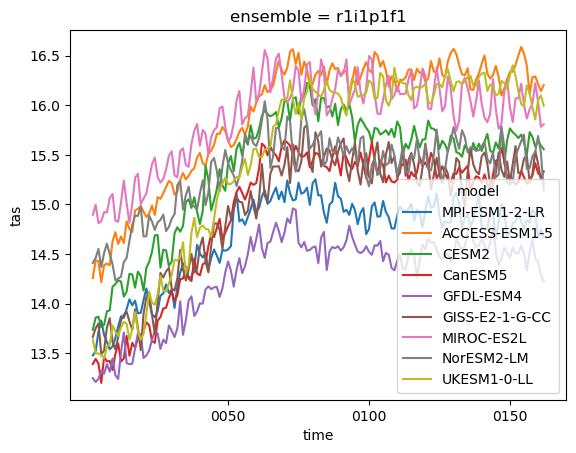

In [24]:
a1_pct_smean_anom_ds.plot(hue='model');

# SN Calculation

In [25]:
# Detrend the data
a1_pct_smean_anom_trendfit_ds = stats.trend_fit(a1_pct_smean_anom_ds, method='polynomial', order=4)
a1_pct_smean_anom_detrend_ds = a1_pct_smean_anom_ds - a1_pct_smean_anom_trendfit_ds

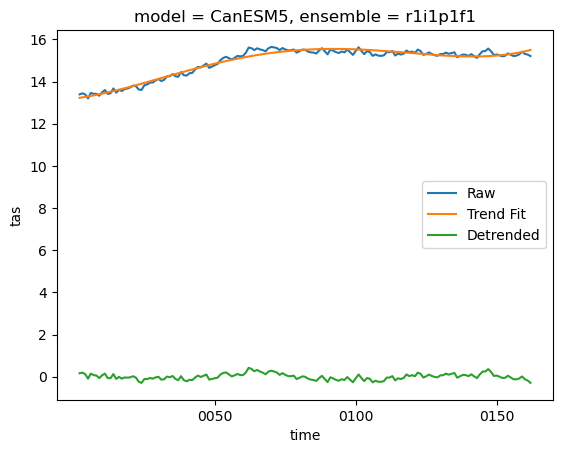

In [26]:
model = 'CanESM5'#'CESM2'
a1_pct_smean_anom_ds.sel(model=model).plot(label='Raw')
a1_pct_smean_anom_trendfit_ds.sel(model=model).plot(label='Trend Fit')
a1_pct_smean_anom_detrend_ds.sel(model=model).plot(label='Detrended')
plt.legend()

In [27]:
# Calculate thje rolling and non rolling signal to noise

# Params to use for both
# Center = False will result in the trends being take from the end: looking back in time
SN_PARAMS = dict(return_all=True, center=False, logginglevel='ERROR')

# Static
sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_pct_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=False,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Rolling
sn_multi_rolling_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_pct_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=True,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Set refkeys and compute
# Remove the first 40 years due to the start being 40 years
sn_multi_static_ds = sn_multi_static_ds.compute().isel(time=slice(40, None))
sn_multi_rolling_ds = sn_multi_rolling_ds.compute().isel(time=slice(40, None))

NameError: name 'a1_smean_anom_detrend_ds' is not defined

In [ ]:
# As this is using the 1%CO2 run into this, we want to now remove this.
# This is best done with the xarray xrlist
models = sn_multi_rolling_ds.model.values
the_list = [sn_multi_rolling_ds.sel(model=model) for model in models]
sn_xrlist = listXarray(the_list, key_dim='model')

# Now have to figure out when the branch to the list xarray occured
to_concat = []
for model in sn_xrlist.refkeys:
    transition_arg = transition_arg_dict[model]
    ds = sn_xrlist[model]
    ds = ds.isel(time=slice(transition_arg-40, None))
    ds = utils.reset_time_to_0_start(ds)
    to_concat.append(ds)
sn_multi_rolling_ds = xr.concat(to_concat, dim='model')

In [ ]:
# sn_multi_rolling_ds = utils.reset_time_to_0_start(sn_multi_rolling_ds)
# sn_multi_static_ds = utils.reset_time_to_0_start(sn_multi_static_ds)

In [ ]:
# This is the length that all of the plots shoudl go to
# The end window is from the np.arange, and so goes to one before (so subtract one).
max_effective_length = len(sn_multi_rolling_ds.time.values)# - (constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS['end_window']-1)
max_effective_length

In [ ]:
# Calculate the year that each is stable
# I want both a dataset version (all ensembles) and a da version (ensemble mean but easier to use)

# Rolling
rolling_year_stable_ds = sn.get_stable_year_ds(sn_multi_rolling_ds, max_effective_length=max_effective_length)

# Static
static_year_stable_ds =sn.get_stable_year_ds(sn_multi_static_ds, max_effective_length=max_effective_length)

static_year_stable_ds

In [ ]:
# # Number of models stable at each time step.
rolling_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)
static_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)

In [ ]:
# Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_ds = sn_multi_rolling_ds.utils.above_or_below(**above_or_below_kwargs)

In [ ]:
# For each window get the number of years that are stable forn each point in time
decreasing_ds = xr.where(unstable_rolling_ds < 0, 1, 0)
increasing_ds = xr.where(unstable_rolling_ds> 0, 1, 0)

# Plots

In [ ]:
def format_null_axis(ax):
    '''
    Axis that doesn't have any spines, or y tick labels or locaionts
    '''
    [ax.spines[sp].set_visible(False) for sp in ['top', 'left', 'right']]
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('')
    ax.set_ylabel('')

In [ ]:
# Manual Calculation for Demonstations
WINDOW=25
# Sample period is the years that we want to look at
sample_period = (0,WINDOW) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW
imodel = 2

In [ ]:
sample_data = a1_smean_anom_ds.isel(time=slice(*sample_period), model=imodel)

In [ ]:
reload(sn_plotting)

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(12,20))
axes = [fig.add_subplot(3,1,i) for i in range(1,3)]


# ---> axes[0]
axes[0].plot(sample_data.time.dt.year.values, sample_data.values, marker='o', label='Simulation', color='green')
axes[0].plot(sample_data.time.dt.year.values, a1_smean_anom_trendfit_ds.isel(time=slice(*sample_period), model=imodel),
             label='Lienar Trend Fit', color='blue')
axes[0].set_xlim(sample_data.time.dt.year.values[0], sample_data.time.dt.year.values[-1])
axes[0].legend(ncol=2, fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(axes[0], title='Signal', xlabel='Time after net zero emissions (years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top', 'right'])
plotting_functions.add_figure_label(axes[0], 'a)')
sn_plotting.format_ticks_as_years(axes[0], sample_data.time.dt.year.values, logginglevel='ERROR')

# ---> axes[1]
ax1 = axes[1]; ax2 = axes[1].twinx()
time = a1_smean_anom_ds.time.dt.year.values
lns1 = ax1.plot(time, a1_smean_anom_ds.isel(model=imodel).values, color='green', label='Simulation')
lns2 = ax1.plot(time, a1_smean_anom_trendfit_ds.isel(model=imodel).values, label='Trend Line', color='green', linestyle=':')
lns3 = ax2.plot(time, a1_smean_anom_detrend_ds.isel(model=imodel).values, label='De-trended Simulation', color='blue')
sn_plotting.format_ticks_as_years(axes[1], time, logginglevel='ERROR')
axes[1].set_xlim(np.take(time, [0, -1]))


plotting_functions.match_ticks(ax1, ax2, 'left')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, ncol=3, loc='best', fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(ax1, title='Noise', xlabel='Time after net zero emissions (years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])
plotting_functions.format_axis(ax2, title='Noise', ylabel='GMST\nAnomaly\nDetrended' + r'($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])
plotting_functions.add_figure_label(ax1, 'b)')

In [ ]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]
experiment_params

In [ ]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''

In [ ]:
reload(sn_plotting)

In [ ]:
fig, ax = sn_plotting.plot_average_stable_year(static_year_stable_ds, rolling_year_stable_ds) # , xlabel='Time (Years)'

In [ ]:
#### Note, this dictionary has also been put into constants as ZECMIP_MODEL_COLORS

# Create a list of models and their corresponding values
model_values = [(model, zec50_ds.sel(model=model).values.round(3)) for model in zec50_ds.model.values]

# Separate negative and positive values
negative_values = [(model, value) for model, value in model_values if value < 0]
positive_values = [(model, value) for model, value in model_values if value > 0]

# Sort the values by their absolute magnitude
negative_values.sort(key=lambda x: abs(x[1]))
positive_values.sort(key=lambda x: abs(x[1]))

# Create a colormap for negative values (BuPu_r) and positive values (OrRd)
# For the Blues we want to remove the three lower values there are too hard to see.  For the reds, just make sure it
# isn't the lower values. 
cut1 = 2
negative_colors = plt.cm.get_cmap('BuPu_r', len(negative_values)+cut1)(np.arange(len(negative_values)+cut1))[:-cut1]
positive_colors = plt.cm.get_cmap('OrRd', len(positive_values)+4)(np.arange(len(positive_values)+4))[::2][-2:]

# Create dictionaries for negative and positive values with color information
negative_zec50 = {model: {'value': value, 'color': color} for (model, value), color in zip(negative_values, negative_colors)}
positive_zec50 = {model: {'value': value, 'color': color} for (model, value), color in zip(positive_values, positive_colors)}

# Combine the dictionaries into the final zec50_dict
zec50_dict = {**negative_zec50, **positive_zec50}
zec50_dict

In [ ]:
rolling_year_stable_ds.time.plot(y='window', hue='model')

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for num, model in enumerate(zec50_dict):
    color = zec50_dict[model]['color']
    rolling_year_stable_ds.sel(model=model).time.plot(ax=ax, y='window', linewidth=2.5, alpha=0.8, color=color, label=model)
        
rolling_year_stable_ds.time.mean(dim='model').plot(ax=ax, y='window', linewidth=3, alpha=0.8, color='k', label='Mean')     
leg = ax.legend()
leg.set_title('Model')
leg.get_title().set_fontsize(constants.PlotConfig.legend_title_size)
plotting_functions.format_axis(ax, xlabel='Time (Years)', ylabel='Window Length\n(Years)', invisible_spines=['top', 'right'])
ax.set_ylim([10, 40])
ax.set_title('')

In [ ]:
sn_levels = np.arange(-4.5, 4.5+.5, 0.5)

In [ ]:
# stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel=f'GMST Anomaly({units})',
#                                   cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
#                                   cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise\nRatio', hspace=0.2,
#                                   return_all=True, rotation=90)

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, max_effective_length), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [ ]:
reload(sn_plotting)
reload(plotting_functions)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    ax, ax2, cax = returned_axes
    #ax.axvline(unstable_rolling_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=5, linestyle=':')
    #ax.axvline(unstable_rolling_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=5, linestyle=':')
    if (num+1)%2: # Left plot
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        plotting_functions.clip_axis_ends(ax)
    else: # Right plot
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(' ')
        plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (years)', size=constants.PlotConfig.title_size*1.4)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=constants.PlotConfig.title_size*1.4)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', size=constants.PlotConfig.title_size*1.4)
    
    if num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*0.7,  sn_plotting.plot_kwargs['height']*num_plots/1.5))
gs = gridspec.GridSpec(num_plots+1, 2, height_ratios=num_plots*[1] + [0.2],
                       width_ratios=[1, 0.2], hspace=sn_plotting.plot_kwargs['hspace']*1.1)

axes_left = [fig.add_subplot(gs[i, 0]) for i in range(num_plots)]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(num_plots)]
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num+1, :])
    
    sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes_left[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title=model, yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs)  
    
    # Lower and upper bound plots
    sn_multi_rolling_ds.sel(model=model).upper_bound.plot(ax=axes_right[num], y='window', color='red', label='Upper Bound')
    sn_multi_rolling_ds.sel(model=model).lower_bound.plot(ax=axes_right[num], y='window', color='blue',label='Lower Bound')
    plotting_functions.format_axis(axes_right[num], xlabel='Signal-to-Noise Ratio', ylabel='',title='', font_scale=1.2)
    format_null_axis(axes_right[num])
    if num == len(models)-1:axes_right[num].legend(ncol=1, fontsize=18)
# axes = axes_left.extend(axes_right)
# for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=1.4)

In [ ]:
stability_colorplot_kwargs_no_temp_line = dict(max_color_lim=max_effective_length, xlims=(0, max_effective_length),patch=False,
                                               ax2_ylabel=f'GMST Anomaly({units})', labelpad_left=70)

In [ ]:
plot_kwargs = {'exp_type': 'zecmip','levels': np.arange(0, 11, 1), 'tick_offset': 'center',
               'extend': 'neither', 'cbar_label': 'Number of Unstable Models'}

In [ ]:
my_blues = plotting_functions.create_discrete_cmap('BuPu', levels=plot_kwargs['levels'], add_white=True)

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Decreasing Temperature Trends', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*1.6))

gs = gridspec.GridSpec(4,1, height_ratios=[1, 1, 0.2, 0.1], hspace=0)
axes = [fig.add_subplot(gs[i]) for i in [0, 1, 3]]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='',#'Decreasing Temperature Trends',
    ylabel='',
    bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='', ylabel='', #'Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for ax in axes[:2]:
    ax.axvline(increasing_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=5, linestyle=':')
    ax.axvline(increasing_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=5, linestyle=':')
axes[0].set_ylabel(''); axes[1].set_ylabel('')
axes[1].annotate('Window Lenght (years)', xy=(-.06, 0.7), size=35, xycoords='axes fraction', clip_on=False, rotation=90)
# for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')
axes[0].set_xticklabels([]);

In [ ]:
#### Rolling VS Static Noise

%matplotlib inline
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    rolling_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Rolling Noise', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model')
    , cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Static Noise',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
# Noise Median
noise_levels = sn_plotting.create_levels(vmax=.2, vmin=0, step=.01)
sn_plotting.plot_heatmap(sn_multi_rolling_ds.noise.median(dim='model'), levels=noise_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='BuPu', extend='max', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

In [ ]:
models = a1_smean_anom_ds.model.values

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = esmpi_smean_ds.sel(model=model).squeeze()
    mean = ds.mean().values
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim(*(mean* 0.75, mean*1.25))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
esmpi_smean_xrlist

In [ ]:
yticks = ax.get_yticks()[1:-1]
yticks

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = axes[num]
    # ds = utils.reset_time_to_0_start(ds)
    # ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    mid_points = np.round(ds.median().values.item(), 0)
    ax.set_ylim([mid_points-1, mid_points+1])
    ax.set_yticks(ax.get_yticks()[1:-1])
    #ax.set_yticks(np.arange(mid_points-0.5, mid_points+.75, 0.25))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    # if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
#     #ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [7, 8]: ax.set_xticklabels('')

# leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
# axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds2 = a1_smean_xrlist[model]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    ds = utils.reset_time_to_0_start(ds)
    ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    ds_base = ds.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period')

    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25 Period')
    
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50 Period')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([12, 18])
    ax.set_yticks(np.arange(13, 18, 1))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [7, 8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=1, bbox_to_anchor=[.9, 1.8], fontsize=12)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds2 = a1_smean_xrlist[model]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    ds = utils.reset_time_to_0_start(ds)
    ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    ds_base = ds.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period')

    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25 Period')
    
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50 Period')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([12, 18])
    ax.set_yticks(np.arange(13, 18, 1))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [7, 8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ds2 = a1_smean_xrlist[model]
    ax = axes[num]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.isel(time=slice(None, -1))
    ax.plot(ds.time.values, ds.squeeze().values, label='1% CO2')
    ax.plot(ds2.time.values, ds2.squeeze().values, label='A1')
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    llim = 0.95 * np.min([ds.min().values, ds2.min().values])
    ulim = 1.1 * np.max([ds.max().values, ds2.max().values])
    # llim=12; ulim=18
    ax.set_ylim([llim, ulim])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, np.concatenate([ds.time.values, ds2.time.values]), 
                              np.concatenate([ds.time.dt.year.values, ds2.time.dt.year.values])-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(ds2.time.values[0], llim, ulim, color='red')


axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
fig = plt.figure(figsize=(8, 15))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(a1_smean_anom_ds.model.values):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    #ax.axhline([0], zorder=-10, color='grey', alpha=0.3, linestyle='--')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);